<a href="https://colab.research.google.com/github/Sou-eu-Miguel/analise-violacoes/blob/main/analise_violacoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Biblioteca base
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, pearsonr, spearmanr
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import math

## Setup do Arquivo

Nesta seção, será realizado o setup inicial do arquivo de dados, incluindo a leitura do arquivo, a visualização das primeiras linhas e a verificação dos tipos de dados para garantir que estejam em formatos adequados para análise.

In [2]:
df = pd.read_excel('/content/violacoes.xlsx', index_col=0)
df.head()

,data_target,data_commit,hash,linhas,Violações_dependencias,Violações_camada_pura,Violações_total
servico,,,,,,,
JNR,2020-04-10,2020-04-09,96fc2fe95cc28d63b1e0fd493f2878e6caf53d85,1257,1,0,1
JNR,2020-05-10,2020-05-08,de986fd946f0bb86b286457a8e301cee66e06b25,2559,4,0,4
JNR,2020-06-10,2020-06-08,d767c22fdfb53a933262975f6c219178a6ce421c,2563,4,0,4
JNR,2020-07-10,2020-07-08,462b631db13b7bd39b1de10e5d61109463dddce5,2653,4,0,4
JNR,2020-08-10,2020-08-06,1e72651f3be78567415a3bdfa66b0300c1d0e126,3655,4,0,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231 entries, JNR to NNS
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   data_target             231 non-null    datetime64[ns]
 1   data_commit             231 non-null    datetime64[ns]
 2   hash                    231 non-null    object        
 3   linhas                  231 non-null    int64         
 4   Violações_dependencias  231 non-null    int64         
 5   Violações_camada_pura   231 non-null    int64         
 6   Violações_total         231 non-null    int64         
dtypes: datetime64[ns](2), int64(4), object(1)
memory usage: 14.4+ KB


## Tratamento de Dados

Nesta seção, serão realizados alguns tratamentos iniciais nos dados. Será removida uma coluna que não será utilizada na análise e o índice do DataFrame será resetado para um formato padrão.

In [4]:
df = df.drop(columns=['hash'])
df = df.reset_index()
print(df.head())
print(df.info())

  servico data_target data_commit  linhas  Violações_dependencias  \
0     JNR  2020-04-10  2020-04-09    1257                       1   
1     JNR  2020-05-10  2020-05-08    2559                       4   
2     JNR  2020-06-10  2020-06-08    2563                       4   
3     JNR  2020-07-10  2020-07-08    2653                       4   
4     JNR  2020-08-10  2020-08-06    3655                       4   

   Violações_camada_pura  Violações_total  
0                      0                1  
1                      0                4  
2                      0                4  
3                      0                4  
4                      0                4  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   servico                 231 non-null    object        
 1   data_target             231 non-

### Tratamento de Formato de Datas

Será adaptado o formato das colunas de data para garantir que estejam em formatos adequados para análise temporal.

In [5]:
df['data'] = pd.to_datetime(df['data_target'])
df['mes_ano'] = df['data'].dt.strftime('%b/%Y')
df.head()

,servico,data_target,data_commit,linhas,Violações_dependencias,Violações_camada_pura,Violações_total,data,mes_ano
0,JNR,2020-04-10,2020-04-09,1257,1,0,1,2020-04-10,Apr/2020
1,JNR,2020-05-10,2020-05-08,2559,4,0,4,2020-05-10,May/2020
2,JNR,2020-06-10,2020-06-08,2563,4,0,4,2020-06-10,Jun/2020
3,JNR,2020-07-10,2020-07-08,2653,4,0,4,2020-07-10,Jul/2020
4,JNR,2020-08-10,2020-08-06,3655,4,0,4,2020-08-10,Aug/2020


## Análise de Dados

Nesta seção, serão realizadas análises exploratórias e estatísticas dos dados para identificar padrões, tendências e relações entre as variáveis.

In [6]:
datas_por_servico = df.groupby('servico')['data'].agg(['min', 'max']).reset_index()
datas_por_servico.columns = ['servico', 'data_inicial', 'data_final']

datas_por_servico.head()

,servico,data_inicial,data_final
0,ADD,2022-05-10,2025-06-10
1,JNR,2020-04-10,2025-06-10
2,LND,2020-11-10,2025-06-10
3,MZR,2022-06-10,2025-06-10
4,NNS,2022-06-10,2025-06-10


In [7]:
servicos = df['servico'].unique()
scaler = MinMaxScaler()

In [8]:
def correlacao(df_serv, col_violacao):
  _, p_shapiro_linhas = shapiro(df_serv['linhas'])
  _, p_shapiro_violacoes = shapiro(df_serv[col_violacao])

  if p_shapiro_linhas > 0.05 and p_shapiro_violacoes > 0.05:
      corr_tipo = 'Pearson'
      corr = pearsonr(df_serv['linhas'], df_serv[col_violacao])
  else:
      corr_tipo = 'Spearman'
      corr = spearmanr(df_serv['linhas'], df_serv[col_violacao])
  print(f"Servico: {df_serv['servico'].unique()} Correlação ({corr_tipo}): r = {corr[0]:.3f}, p = {corr[1]:.4f}")
  return corr

In [9]:
def regressao(def_serv, col_violacao):
  X = sm.add_constant(df_serv['linhas'])
  y = df_serv[col_violacao]
  return sm.OLS(y, X).fit()

In [10]:
for servico in servicos:
  df_serv = df[df['servico'] == servico].sort_values(by='data').copy()
  df_serv[['linhas_norm', 'violacoes_norm']] = scaler.fit_transform(
      df_serv[['linhas', 'Violações_total']]
  )
  corr_val, p_val = correlacao(df_serv, 'Violações_total')

Servico: ['JNR'] Correlação (Spearman): r = 0.950, p = 0.0000
Servico: ['LND'] Correlação (Spearman): r = 0.916, p = 0.0000
Servico: ['ADD'] Correlação (Spearman): r = 0.947, p = 0.0000
Servico: ['MZR'] Correlação (Spearman): r = 0.954, p = 0.0000
Servico: ['NNS'] Correlação (Spearman): r = 0.937, p = 0.0000


In [11]:
for servico in servicos:
  df_serv = df[df['servico'] == servico].sort_values(by='data').copy()
  df_serv[['linhas_norm', 'violacoes_norm']] = scaler.fit_transform(
      df_serv[['linhas', 'Violações_total']]
  )

  modelo = regressao(df_serv, 'Violações_total')
  print(f"===============================Servico: {df_serv['servico'].unique()}===============================")
  print(modelo.summary())
  print()

===============================Servico: ['JNR']===============================
                            OLS Regression Results                            
Dep. Variable:        Violações_total   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     508.3
Date:                Tue, 15 Jul 2025   Prob (F-statistic):           2.79e-31
Time:                        14:26:37   Log-Likelihood:                -57.473
No. Observations:                  63   AIC:                             118.9
Df Residuals:                      61   BIC:                             123.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

### JNR:
A regressão linear para o serviço JNR apresentou um R² de 0.893, indicando que cerca de 89,3% da variação no número de violações pode ser explicada pela quantidade de linhas de código. O coeficiente da variável linhas foi 0.0012, sugerindo que a cada mil linhas adicionadas ao sistema, espera-se em média 1,2 violações a mais. A relação foi altamente significativa (p < 0.001), reforçando a força do modelo. O intercepto (-0.4763) não foi estatisticamente significativo, o que indica que o modelo não prevê bem situações com poucas ou nenhuma linha de código. A estatística de Durbin-Watson (0.485) sugere a presença de autocorrelação nos resíduos, o que pode ser relevante se o fator tempo tiver impacto na estrutura dos dados.

### LND
Para o serviço LND, a regressão também revelou uma relação significativa entre tamanho do código e violações, com um R² de 0.804. O coeficiente de 0.0010 aponta para uma tendência semelhante à de JNR — cerca de 1 violação a cada mil linhas. O modelo foi estatisticamente significativo (p < 0.001) e o intercepto (-1.1827) também foi significativo, embora negativo, o que pode indicar que o modelo tende a superestimar a presença de violações quando o sistema ainda possui poucas linhas. Testes de normalidade dos resíduos (Omnibus e Jarque-Bera) apontam uma leve assimetria, e a baixa estatística Durbin-Watson (0.639) reforça a possibilidade de autocorrelação.

### ADD
O serviço ADD teve um R² de 0.895, o mais alto entre todos, o que demonstra que quase 90% da variação nas violações é explicada pelo número de linhas. O coeficiente de 0.0013 implica uma relação um pouco mais intensa — indicando que o crescimento no número de violações é proporcionalmente maior a cada mil linhas. O modelo é altamente significativo, com p < 0.001, e o intercepto também é significativo e negativo (-4.9500). Assim como nos demais, a estatística Durbin-Watson (0.424) aponta para autocorrelação nos resíduos, o que sugere que o comportamento temporal dos dados não está sendo capturado adequadamente pela regressão simples.

### MZR


### NNS
No serviço NNS, observou-se um R² de 0.712, também indicando uma boa explicação da variabilidade nas violações pela variável linhas. O coeficiente foi menor que nos demais (0.0004), o que mostra uma relação positiva, porém mais branda: são esperadas cerca de 0,4 violações a cada mil linhas adicionadas. O modelo foi altamente significativo (p < 0.001) e o intercepto positivo (10.4890) também foi significativo, sugerindo uma base de violações já existente mesmo com poucas linhas de código. Assim como nos demais serviços, a baixa estatística Durbin-Watson (0.192) indica autocorrelação dos resíduos e reforça a necessidade de considerar dependência temporal em análises futuras.

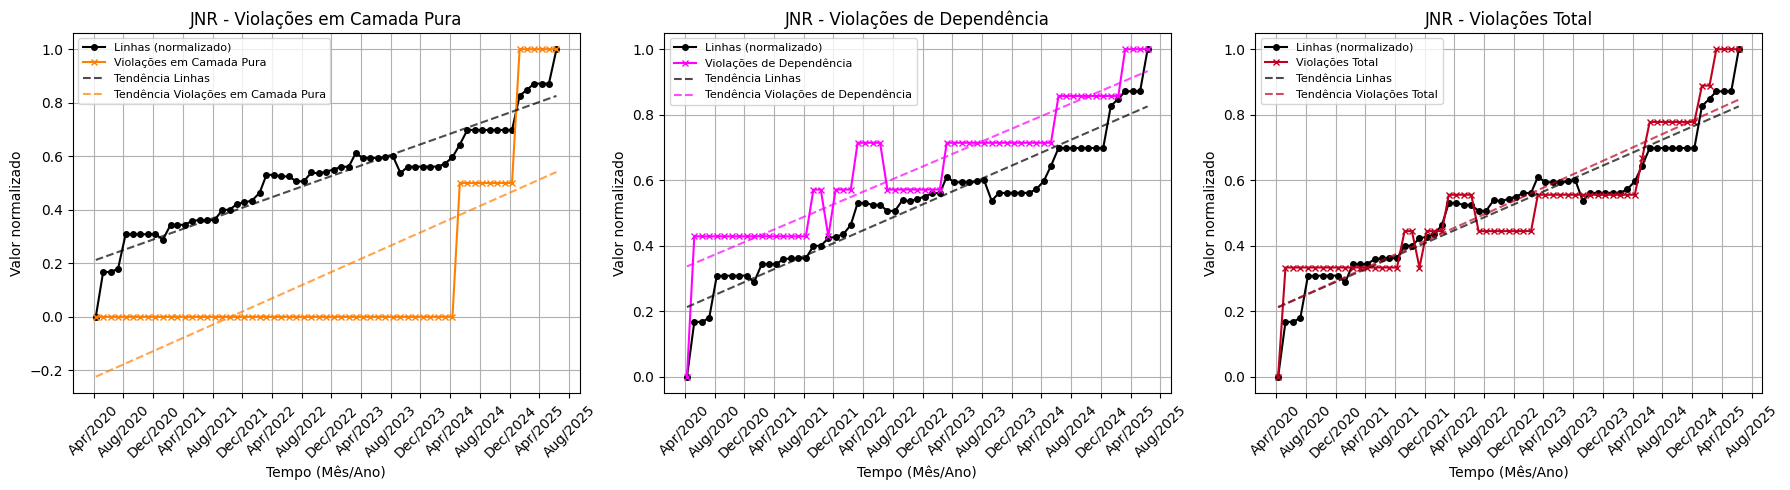

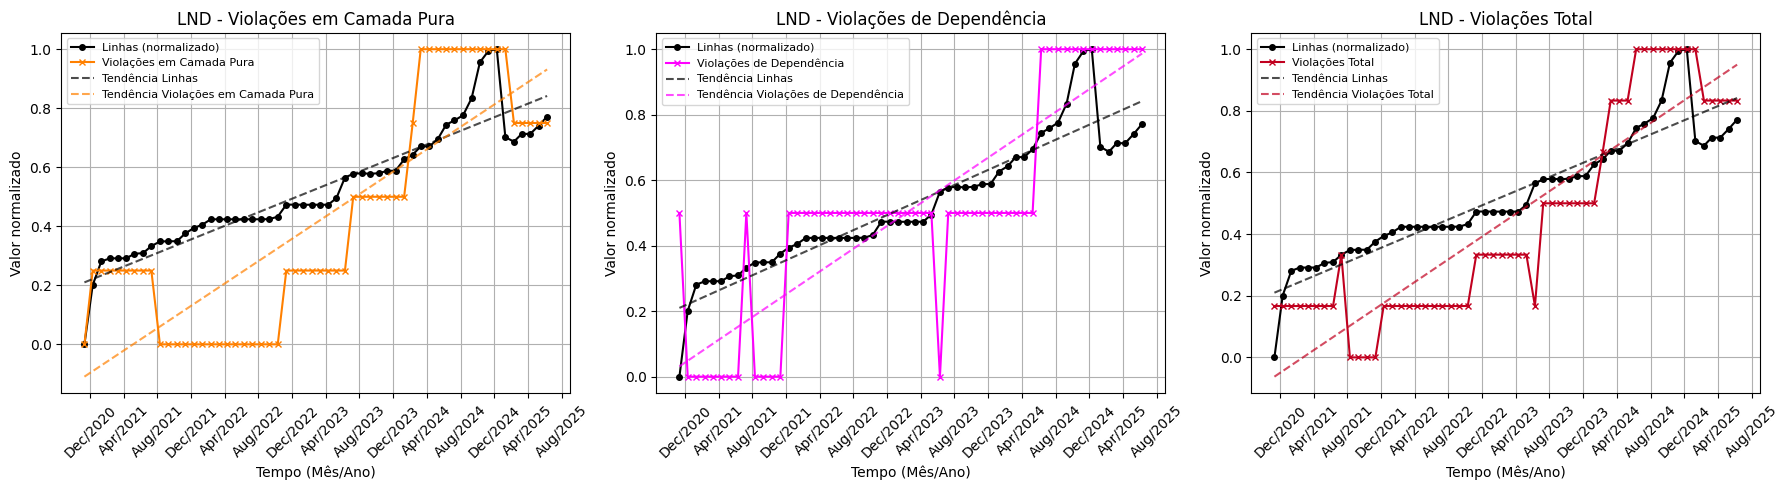

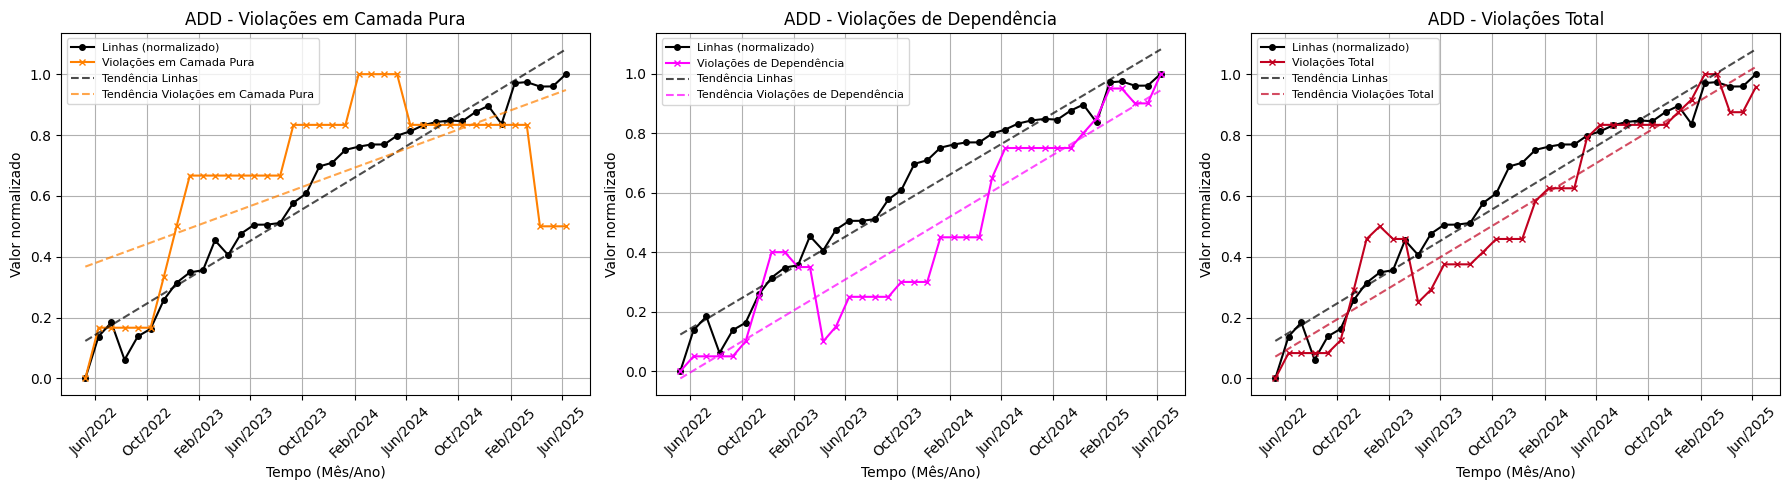

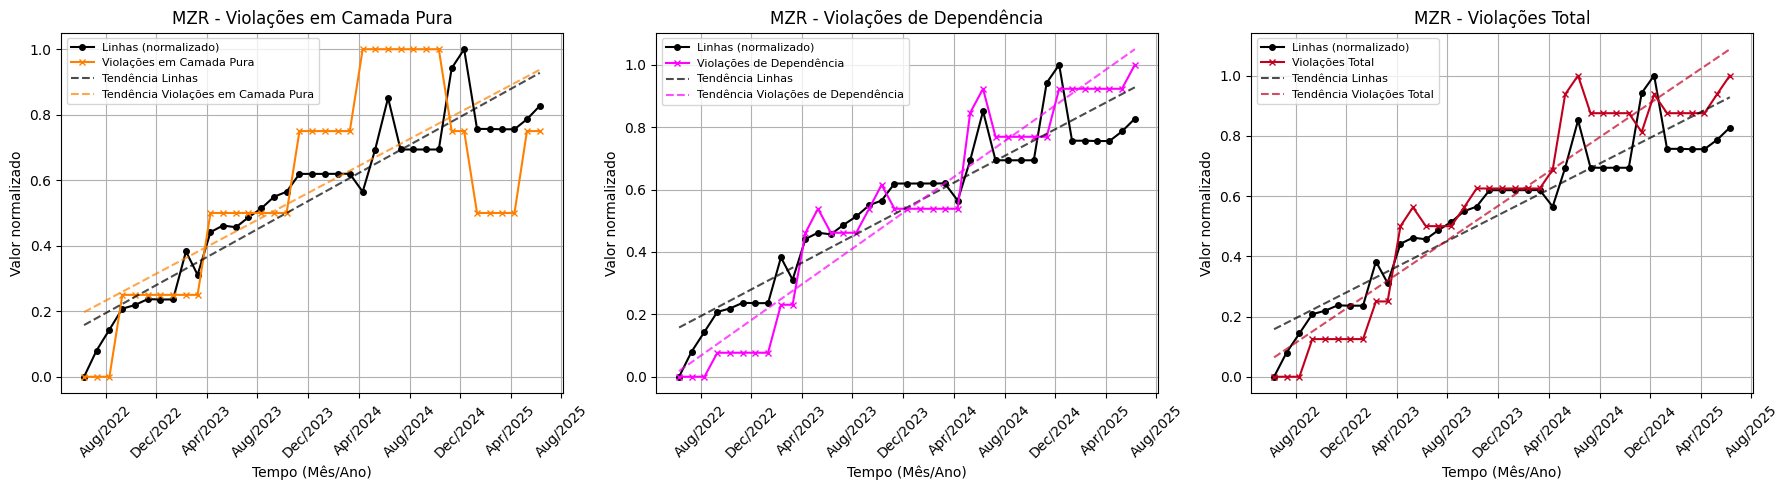

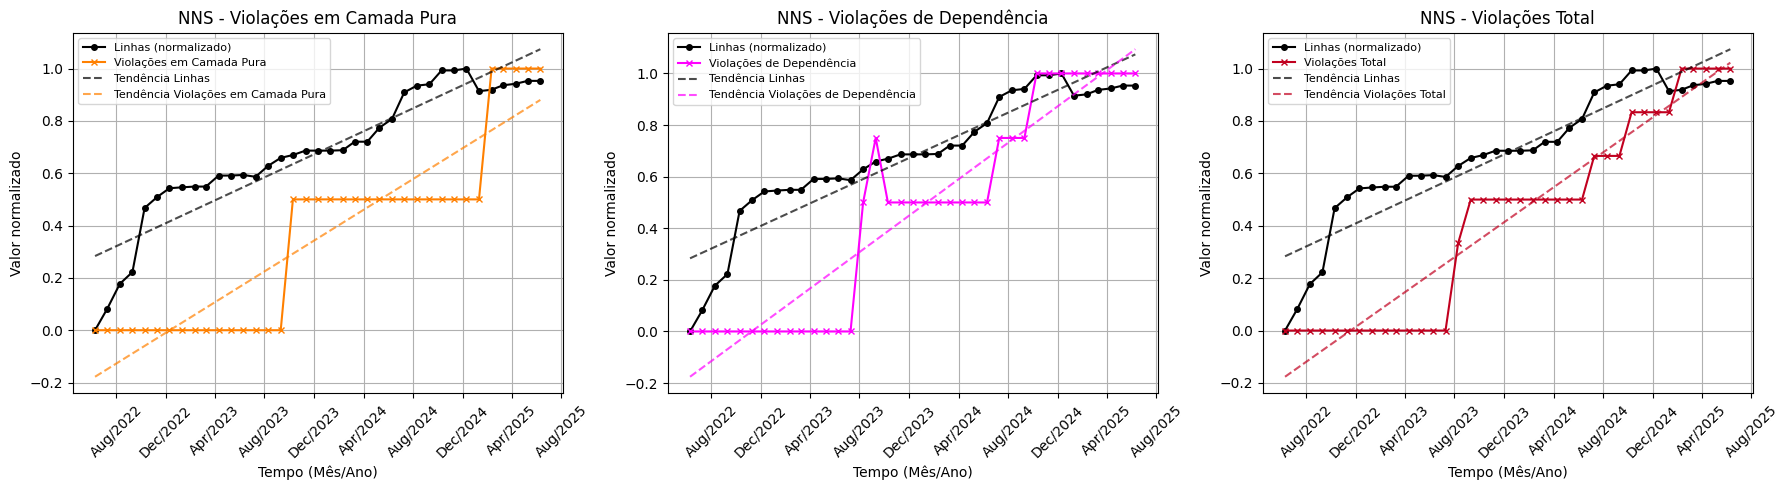

In [12]:
for servico in servicos:
    df_serv = df[df['servico'] == servico].sort_values(by='data').copy()

    df_serv[['linhas_norm', 'violacoes_pura_norm', 'violacoes_dep_norm', 'violacoes_total_norm']] = scaler.fit_transform(
        df_serv[['linhas', 'Violações_camada_pura', 'Violações_dependencias', 'Violações_total']]
    )

    violacoes_info = {
        'violacoes_pura_norm': ('Violações em Camada Pura', '#FF8000'),
        'violacoes_dep_norm': ('Violações de Dependência', '#FF00FF'),
        'violacoes_total_norm': ('Violações Total', '#C1001F')
    }

    cols = 3
    rows = 1
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    x_nums = mdates.date2num(df_serv['data'])

    for i, (col, (label, color)) in enumerate(violacoes_info.items()):
        ax = axes[i]

        ax.plot(df_serv['data'], df_serv['linhas_norm'], label='Linhas (normalizado)', marker='o', color='#000000', markersize=4)
        ax.plot(df_serv['data'], df_serv[col], label=label, marker='x', color=color, markersize=4)

        coef_lin = np.polyfit(x_nums, df_serv['linhas_norm'], 1)
        trend_lin = np.poly1d(coef_lin)(x_nums)
        ax.plot(df_serv['data'], trend_lin, color='#000000', linestyle='--', alpha=0.7, label='Tendência Linhas')

        coef_viol = np.polyfit(x_nums, df_serv[col], 1)
        trend_viol = np.poly1d(coef_viol)(x_nums)
        ax.plot(df_serv['data'], trend_viol, color=color, linestyle='--', alpha=0.7, label=f'Tendência {label}')

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
        plt.setp(ax.get_xticklabels(), rotation=45)

        ax.set_title(f"{servico} - {label}")
        ax.set_xlabel("Tempo (Mês/Ano)")
        ax.set_ylabel("Valor normalizado")
        ax.legend(fontsize=8)
        ax.grid(True)

        plt.tight_layout()
plt.show()

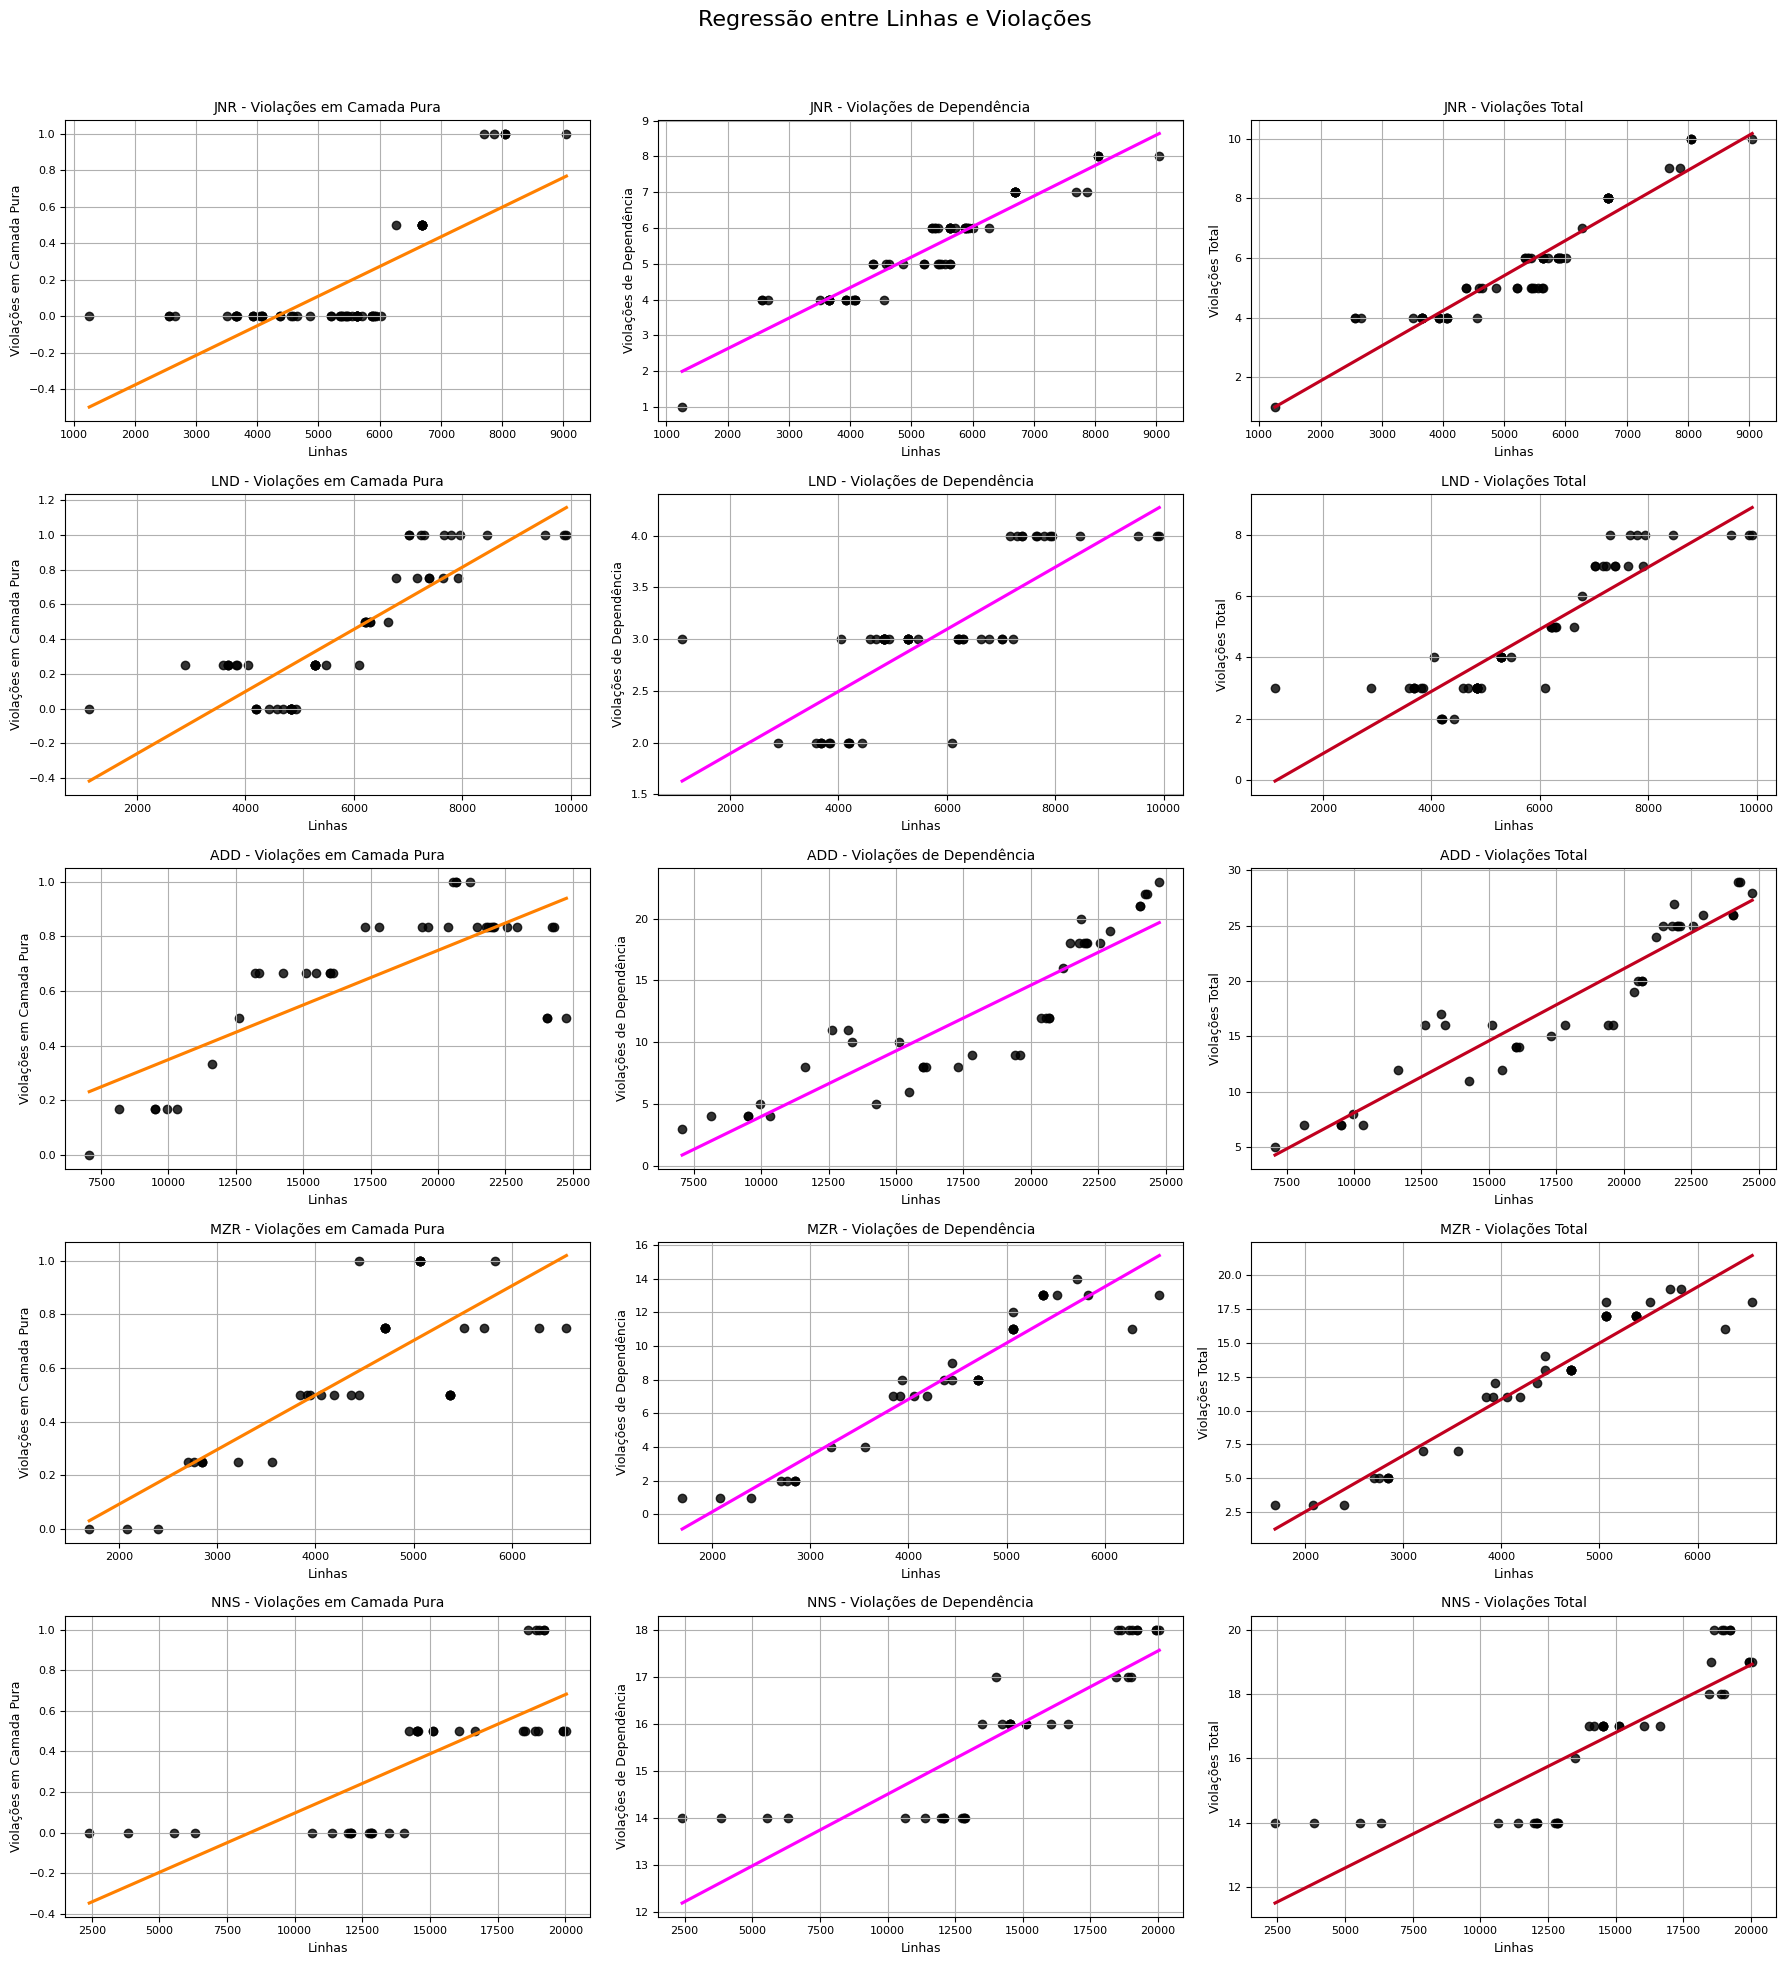

In [13]:
violacoes_info = {
    'violacoes_pura_norm': ('Violações em Camada Pura', '#FF8000'),
    'Violações_dependencias': ('Violações de Dependência', '#FF00FF'),
    'Violações_total': ('Violações Total', '#C1001F')
}

num_servicos = len(servicos)
num_variaveis = len(violacoes_info)
total_plots = num_servicos * num_variaveis

cols = 3
rows = math.ceil(total_plots / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

plot_index = 0

for servico in servicos:
    df_serv = df[df['servico'] == servico].sort_values(by='data').copy()

    df_serv[['linhas_norm', 'violacoes_total_norm', 'violacoes_pura_norm', 'violacoes_dependencias_norm']] = scaler.fit_transform(
        df_serv[['linhas', 'Violações_total', 'Violações_camada_pura', 'Violações_dependencias']]
    )

    for viol_col, (viol_label, color) in violacoes_info.items():
        ax = axes[plot_index]
        sns.regplot(
            x='linhas',
            y=viol_col,
            data=df_serv,
            ci=None,
            line_kws={'color': color},
            scatter_kws={'color': '#000000'},
            ax=ax
        )
        ax.set_title(f"{servico} - {viol_label}", fontsize=10)
        ax.set_xlabel("Linhas", fontsize=9)
        ax.set_ylabel(viol_label, fontsize=9)
        ax.grid(True)
        ax.tick_params(labelsize=8)
        plot_index += 1

for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("Regressão entre Linhas e Violações", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
